## Project Proposal: NBA Trade and Draft Recommender System

Welcome! This notebook is for my proposal of Capstone project for Data Incubator. <br>
I hope to design a NBA Trade and Draft Recommender System, in the hope that the following two questions can be answered:<br>
<b>1.</b> Given a current team combination, which player in the league best fit the team in a certain salary range?<br>
<b>2.</b> Who should I pick in the annual NBA draft?<br><br>
<p>
This notebook is divided into three sections: <br>
<b>1</b>. In order to implement my recommending system, we will need to assign a team score to each NBA team in each NBA season. We will first compute an initial score, which is the TeamPER score we define below. Later in the project we will implement an Elo ranking algorithm to compute an Elo score for each team base on the initial (TeamPER) score, and the head-to-head game records in each season.<br>
<b>2</b>. We provide a scatter plot to show that the TeamPER value we define is of high correlation with the 'Winning Percentage' of each team. We further computed the correlation.<br>
<b>3</b>. In order to answer the second question, we analyzed the rookie performances according to their Pick rank and PER value. We provide two plots: <b>A)</b> a distribution graph that compare the player in the Pick rank (0~15) and (15~30); <b>B)</b> a scatter plot that indicates the correlation between first year PER value and average PER value of all senior players ($\geq 4$ years) in NBA.<br>
        <\p>
Let us now dive in!


In [1]:
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nba = pd.read_csv('nba_data/Seasons_Stats.csv', index_col = 0)

# We take the most recent 20 years nba stats. Since the game of basket ball is evolving. The stats too far back may be not as valuable.
nba = nba.loc[nba.Year>1997]
nba.reset_index(drop = True, inplace = True)

# We convert the Year column in nba dataframe to integer
nba.Year = nba.Year.apply(lambda x: int(x))

# Rename the column name from 'Tm' to 'Team'
nba.rename(columns ={'Tm':'Team'}, inplace = True)

In [3]:
nba.head()

,Year,Player,Pos,Age,Team,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1998,Mahmoud Abdul-Rauf,PG,28.0,SAC,31.0,0.0,530.0,10.5,0.405,...,1.000,6.0,31.0,37.0,58.0,16.0,1.0,19.0,31.0,227.0
1,1998,Tariq Abdul-Wahad,SG,23.0,SAC,59.0,16.0,959.0,10.1,0.456,...,0.672,44.0,72.0,116.0,51.0,35.0,13.0,65.0,81.0,376.0
2,1998,Shareef Abdur-Rahim,SF,21.0,VAN,82.0,82.0,2950.0,21.1,0.562,...,0.784,227.0,354.0,581.0,213.0,89.0,76.0,257.0,201.0,1829.0
3,1998,Cory Alexander,PG,24.0,TOT,60.0,22.0,1298.0,15.2,0.548,...,0.784,17.0,129.0,146.0,209.0,70.0,11.0,112.0,98.0,488.0
4,1998,Cory Alexander,PG,24.0,SAS,37.0,3.0,501.0,11.1,0.512,...,0.676,7.0,40.0,47.0,71.0,25.0,5.0,47.0,53.0,165.0


In [4]:
# We drop the terms with 'TOT' in the Team column. 'TOT' means this player has played for two different teams in a single season
nba = nba[nba.Team != 'TOT']

In [5]:
#Read in the standings file
standings = pd.read_csv('nba_data/NBA_standings.csv')
standings.Record = standings.Record.apply(lambda x: '12-70' if x=='Dec-70' else x)
standings.Record = standings.Record.apply(lambda x: '07-59' if x=='Jul-59' else x)
standings.Record = standings.Record.apply(lambda x: '11-71' if x=='Nov-71' else x)
standings.Record = standings.Record.apply(lambda x: '08-42' if x=='Aug-42' else x)
standings.Record = standings.Record.apply(lambda x: '10-72' if x=='Oct-72' else x)

def winning_per(x):
    return float(x[:2])/82*100
standings['Winning Percentage'] = standings.Record.apply(lambda x:winning_per(x))
standings = standings.rename(columns={'Winning Percentage': 'Win_Pct'})

In [6]:
standings.head()

,Year,Team,Record,Win_Pct
0,2017,BOS,53-29,64.634146
1,2017,ATL,43-39,52.439024
2,2017,BRK,20-62,24.390244
3,2017,CHO,36-46,43.902439
4,2017,CHI,41-41,50.000000


## TeamPER score
Our Goal now is to compute the TeamPER score as our initial score of the team.<br>
The Team PER for each team is computed as follows:<br>

1. Pick top 12 players in each team that played the most minutes (MP).<br>
2. We compute the product of individual PER score and the Minuted Played for each player.<br>
3. We sum the value above among the top 12 players. Normalize the value to a reasonable range.<br>

Mathematically, the formula is expressed as follows:
$$ TeamPER = (\frac{\sum_\text{Top 12 in MP} \text{Individual PER}* \text{Minutes Played (MP)}}{100000})^5$$
Note the the denominator ($100000$) is only for normalizing the value within a reasonable range. The fifth power gives the highest correlation (as well as the $R^2$ stats) between the TeamPER and the Win Percentage among $[1,10]$.<br>
We will see below that this TeamPER score behave relatively well. But during the capstone project, I will use a linear regression to find out the best coefficients for a polynomial in the definition of TeamPER.

In [7]:
#Define a new column named 'totPER' that gives PER*MP for each player
nba['totPER'] = nba.MP*nba.PER

In [8]:
#compute the team PER
def team_PER(x):
    x = x.sort_values('MP', ascending = False).reset_index(drop=True)[:12]
    # We square the totPER while keeping the size managable.
    team_PER = (x.totPER.sum()/100000)**5
    return team_PER

# Apply the function on each group
team_PER = nba.groupby(by = ['Year','Team']).apply(lambda x: team_PER(x))

#Change the series into frame and set the index
team_PER = team_PER.to_frame().reset_index()
team_PER = team_PER.rename(columns ={0:'TeamPER'})

In [9]:
# Now merge the two dataframe standings and grouped on 
all_teams = pd.merge(standings, team_PER, on = ['Year', 'Team'])
all_teams.head()

,Year,Team,Record,Win_Pct,TeamPER
0,2017,BOS,53-29,64.634146,229.488304
1,2017,ATL,43-39,52.439024,133.691777
2,2017,BRK,20-62,24.390244,73.699062
3,2017,CHO,36-46,43.902439,221.093977
4,2017,CHI,41-41,50.000000,174.912376


## First Graph: The Correlation between Winning Percentage and TeamPER score

Correlation between Win_Pct and TeamPER, which is indeed significant. This means that it is suitable for our initial choice of the team score.

In [10]:
corr_teamPER = all_teams.Win_Pct.corr(all_teams.TeamPER)
corr_teamPER

0.7948014740527295

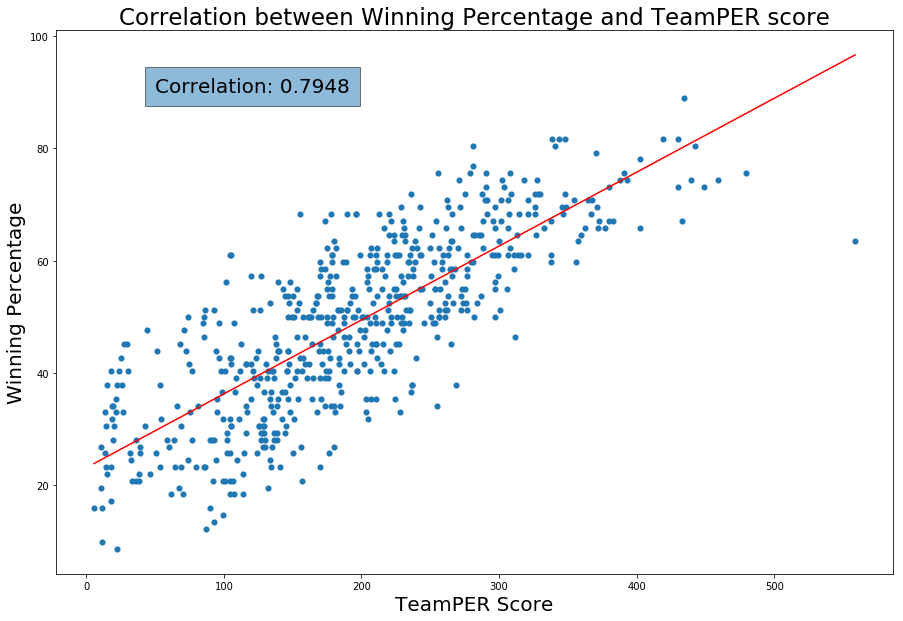

In [37]:
# We now plot the TeamPER score and the Win_Pct
x = all_teams.TeamPER
y = all_teams.Win_Pct

plt.figure(figsize = (15,10))
ax = plt.scatter(x, y, linewidth = 0.1)
plt.text(50,90,'Correlation: 0.7948', fontsize=20, bbox={'alpha':0.5, 'pad':10})
plt.xlabel('TeamPER Score', fontsize=20)
plt.ylabel('Winning Percentage', fontsize=20)
plt.title('Correlation between Winning Percentage and TeamPER score', fontsize=23)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = 'r')

## Leading to the second Graph: Rookies PER
We will now analyze the PER values for rookies in the past 20 years.<br>
The goal here is to find out a pattern among the rookies. This can be informative for NBA managers for their picks in the NBA draft. <br>
During the capstone project, I plan to compare the performances of each player before and after they were drafted. In the comparison I hope to figure out a weight that can be used to predict the potential PER value of each rookie in the NBA.

In [12]:
# Take the 'Year', 'Pk' and 'Player' columns from nba_Rookies.csv 
rookies = pd.read_csv('nba_data/nba_Rookies.csv', )
rookies = rookies.loc[:,['Year', 'Pk', 'Player']]

# We add 1 to the Year column since in the other form, a player's stats in season 13-14 is counted as 2014
rookies.Year = rookies.Year.apply(lambda x: x+1)

In [13]:
# We find the first appearance of each player in the nba dataframe, pull their PER
def first_year_PER(x):
    x = x.sort_values('Year').reset_index(drop=True)
    x = x.loc[:,['Year','PER']]
    return x
grouped = nba.groupby(by = ['Player']).apply(lambda x: first_year_PER(x))
grouped.reset_index(inplace = True)
grouped = grouped.drop(axis = 1, columns = ['level_1'])
grouped = grouped.rename(columns = {'PER':'firstPER'})

# We join the two forms to find the rookie year PER of these players
rookies_PER = pd.merge(rookies, grouped, on = ['Year','Player'])

In [14]:
# Find the players who has played more than 4 years
nba_senior = nba.groupby('Player').filter(lambda x: x.max()['Year']-x.min()['Year']>=4)

# Compute the max PER for each senior player
senior_player_max = nba_senior.groupby(by = ['Player']).max()['PER']
senior_player_max = senior_player_max.to_frame().reset_index()
senior_player_max = senior_player_max.rename(columns = {'PER':'maxPER'})

# Compute the average PER for each senior player
senior_player_ave = nba_senior.groupby(by = ['Player']).mean()['PER']
senior_player_ave = senior_player_ave.to_frame().reset_index()
senior_player_ave = senior_player_ave.rename(columns = {'PER':'avePER'})

senior_player = pd.merge(senior_player_max, senior_player_ave, on=['Player'])

# Compute the PER increasing rate for each senior player
senior_player_rate = nba_senior.groupby(by = ['Player']).apply(lambda x: (x.max()['PER']-x.min()['PER'])/len(x))
senior_player_rate = senior_player_rate.to_frame().reset_index()
senior_player_rate = senior_player_rate.rename(columns = {0: 'PER_rate'})

senior_player = pd.merge(senior_player, senior_player_rate, on=['Player'])

#Merge it back to the rookie list to find the rookies who later played in the league for more than 4 years
senior_player = pd.merge(rookies_PER, senior_player, on=['Player'])
senior_player.head()

,Year,Pk,Player,firstPER,maxPER,avePER,PER_rate
0,2004,1,LeBron James,18.3,31.7,27.700000,0.957143
1,1998,1,Tim Duncan,22.6,27.1,23.931579,0.536842
2,1999,9,Dirk Nowitzki,12.8,28.1,22.178947,0.805263
3,2006,4,Chris Paul,22.1,30.0,25.625000,0.666667
4,1999,10,Paul Pierce,19.2,23.6,18.557895,0.942105


## Second Graph: Performances of First Round Rookies.

We plot the distributions of the average PER for the players in Rank 1~15 and in Rank 16~30. We can find out that the median of average PER of the earlier picks (1~15, in blue) are indeed higher than the average PER of the later picks (16~30, in red).<br>
An interesting find is that the shape of the distribution of the later picks (16~30, in red) is slightly narrower than the earlier picks (1~15, in blue), indicating a lower variance in the performance in the lower picks. Therefore it is slightly less risky and more guaranteed for picks within range 16~30.

Text(0.5,1,'Distribution of the Average PER of the First Round Rookies')

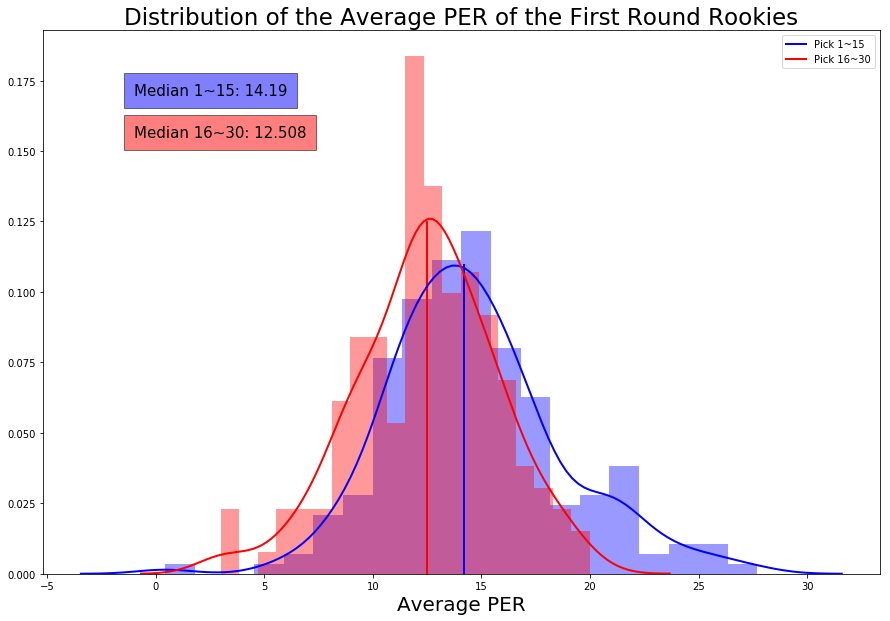

In [53]:
plt.figure(figsize = (15,10))
#We plot the distributions of the avePER for the players in Rank 1~15
x1 = senior_player[(senior_player.Pk>0) & (senior_player.Pk<=15)]['avePER']
sns.distplot(x1, bins = 20, kde_kws={"color": "b", "lw": 2, "label": "Pick 1~15"},
             hist_kws={"linewidth": 1,"color": "b"})
median1 = np.median(senior_player[(senior_player.Pk>0) & (senior_player.Pk<=15)]['avePER'])
plt.vlines(median1, 0, 0.11, colors = 'b', linewidth = 2)

#We plot the distributions of the avePER for the players in Rank 16~30
x2 = senior_player[(senior_player.Pk>15) & (senior_player.Pk<=30)]['avePER']
sns.distplot(x2, bins = 20, kde_kws={"color": "r", "lw": 2, "label": "Pick 16~30"},
             hist_kws={"linewidth": 1,"color": "r"})
median2 = np.median(senior_player[(senior_player.Pk>15) & (senior_player.Pk<=30)]['avePER'])
plt.vlines(median2, 0, 0.125, colors = 'r', linewidth = 2)

plt.text(-1,0.17, 'Median 1~15: '+str(round(median1,4)), fontsize=15, bbox={'facecolor':'b','alpha':0.5, 'pad':10})
plt.text(-1,0.155, 'Median 16~30: '+str(round(median2,4)), fontsize=15, bbox={'facecolor':'r','alpha':0.5, 'pad':10})

plt.xlabel('Average PER', fontsize = 20)
plt.title('Distribution of the Average PER of the First Round Rookies', fontsize = 23)

We computed the correlation between the first year PER and the career-averaged PER for each player. We also computed the correlation between their first year PER and their career max PER. 

In [16]:
first_ave = senior_player.firstPER.corr(senior_player.avePER)
first_max = senior_player.firstPER.corr(senior_player.maxPER)
print('Correlation between the first year PER and the average PER:', first_ave)
print('Correlation between the first year PER and the max PER:',  first_max)

Correlation between the first year PER and the average PER: 0.5719333214425589
Correlation between the first year PER and the max PER: 0.2570145109692055


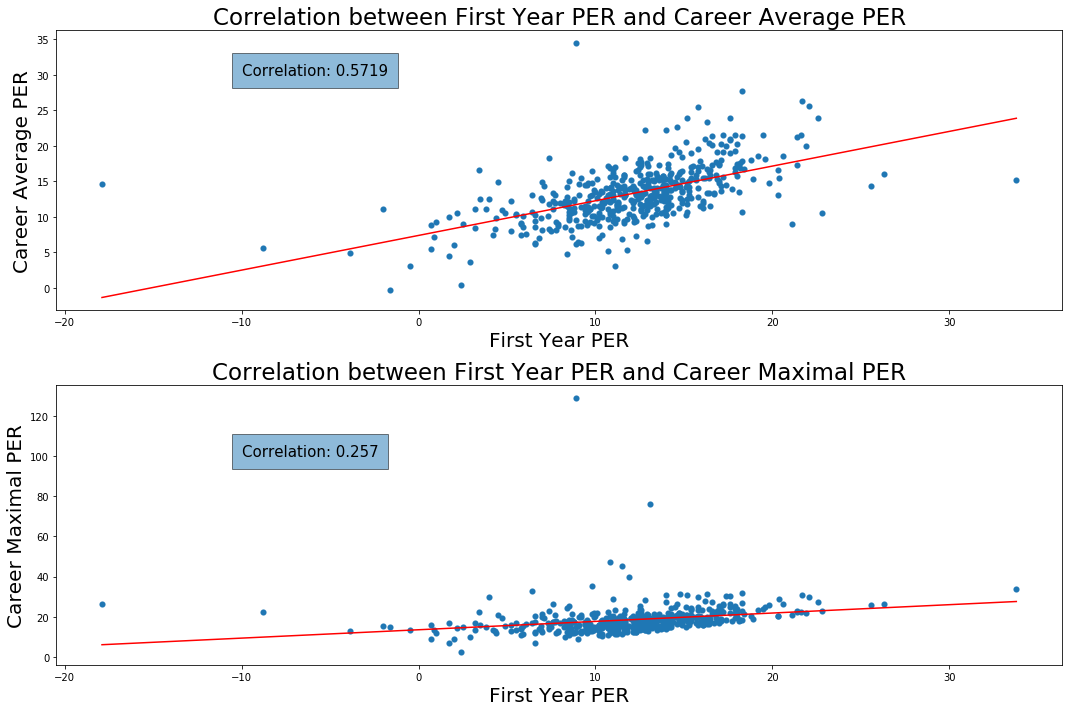

In [58]:
# We now plot the TeamPER score and the Win_Pct
x = senior_player.firstPER
y1 = senior_player.avePER
y2 = senior_player.maxPER

plt.figure(figsize = (15,10))
plt.subplot(211)
ax1 = plt.scatter(x, y1, linewidth = 0.1)
plt.xlabel('First Year PER', fontsize = 20)
plt.ylabel('Career Average PER', fontsize = 20)
plt.title('Correlation between First Year PER and Career Average PER', fontsize = 23)
plt.text(-10,30, 'Correlation: '+str(round(first_ave,4)), fontsize=15, bbox={'alpha':0.5, 'pad':10})
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y1, 1))(np.unique(x)), color = 'r')

plt.subplot(212)
ax2 = plt.scatter(x, y2, linewidth = 0.1)
plt.xlabel('First Year PER', fontsize = 20)
plt.ylabel('Career Maximal PER', fontsize = 20)
plt.title('Correlation between First Year PER and Career Maximal PER', fontsize = 23)
plt.text(-10,100, 'Correlation: '+str(round(first_max,4)), fontsize=15, bbox={'alpha':0.5, 'pad':10})
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)), color = 'r')
plt.tight_layout()